In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## NLP Imports
import nltk
from nltk import FreqDist,word_tokenize,regexp_tokenize,TweetTokenizer
from nltk.corpus import stopwords
import string

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV

import warnings 
warnings.filterwarnings('always')#filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


from nltk import word_tokenize
import nltk
from nltk import TweetTokenizer
tokenizer = TweetTokenizer()

In [2]:
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'latin-1')
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
data['tweet_text'].isna().sum()

1

In [5]:
data[data['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [6]:
data.drop(6, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
print(data.isna().sum())

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5801
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [8]:
data['emotion_in_tweet_is_directed_at'].value_counts(normalize=True)

iPad                               0.287451
Apple                              0.200851
iPad or iPhone App                 0.142814
Google                             0.130659
iPhone                             0.090246
Other Google product or service    0.089031
Android App                        0.024613
Android                            0.023701
Other Apple product or service     0.010635
Name: emotion_in_tweet_is_directed_at, dtype: float64

In [9]:
# change column to product because it make more sense

data.rename(columns={"emotion_in_tweet_is_directed_at": "product",
                     "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"}, inplace=True)

In [10]:
# see what products are getting tweeted at the most, for just columns 
# with known data

df_product = data['product']
def view_uncleaned(data):
    products = data.value_counts()
    return pd.DataFrame({'Count of Tweets':products,
                  '% of Tweets':products/len(data)*100}).round(2)
view_uncleaned(df_product)

,Count of Tweets,% of Tweets
iPad,946,10.40
Apple,661,7.27
iPad or iPhone App,470,5.17
Google,430,4.73
iPhone,297,3.27
Other Google product or service,293,3.22
Android App,81,0.89
Android,78,0.86
Other Apple product or service,35,0.38


In [11]:
# see data that 
df_emotion = data['emotion']
view_uncleaned(df_emotion)

,Count of Tweets,% of Tweets
No emotion toward brand or product,5388,59.26
Positive emotion,2978,32.75
Negative emotion,570,6.27
I can't tell,156,1.72


In [12]:
# Since "I cant tell" group as it is, is not helpful for the business problem 
# I choose to combine it with the no emotion group since they are the most similar

data['emotion'].replace("I can't tell", "No emotion toward brand or product", inplace=True)
data['emotion'].value_counts()

No emotion toward brand or product    5544
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [13]:
#make only two columns to troubleshoot what is going wrong



#data['emotion'][:2000].replace("No emotion toward brand or product", "Positive emotion", inplace=True)
#data['emotion'].value_counts()

In [14]:
#make only two columns to troubleshoot what is going wrong

#data['emotion'][2000:10000].replace("No emotion toward brand or product", "Negative emotion", inplace=True)
#data['emotion'].value_counts()

#### At first glance we notice:
- The data is is missing about 2/3 of the values of what product is being tweeted about(`emotion_in_tweet_is_directed_at`)
- The majority of the tweets have no emotion followed by positive emotion. The count of negative emotion tweets is far behind them both. The data is unbalanced and this will effect the model if not delt with.
- Tweets that fall under the `I can't tell` sediment are not helpful in answering the the business question. I combined that group with the No Emotions group since, they are the most similar & relateable.

In [15]:
# take a closer look into the missing product rows

product_missing = data[data['product'].isnull()]
product_missing.head()

,tweet_text,product,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
15,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
31,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
32,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
33,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product


In [16]:
# majority are neutral emotion, suggests that the tweet is a coversation and not so much geared towards a company

product_missing['emotion'].value_counts()

No emotion toward brand or product    5444
Positive emotion                       306
Negative emotion                        51
Name: emotion, dtype: int64

Since by far the majority of NaN rows are assigned to `Neutral` emotion. I am going to leave it for now and come back to later on in analysis during further cleaning. 

/Users/rachelfein/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


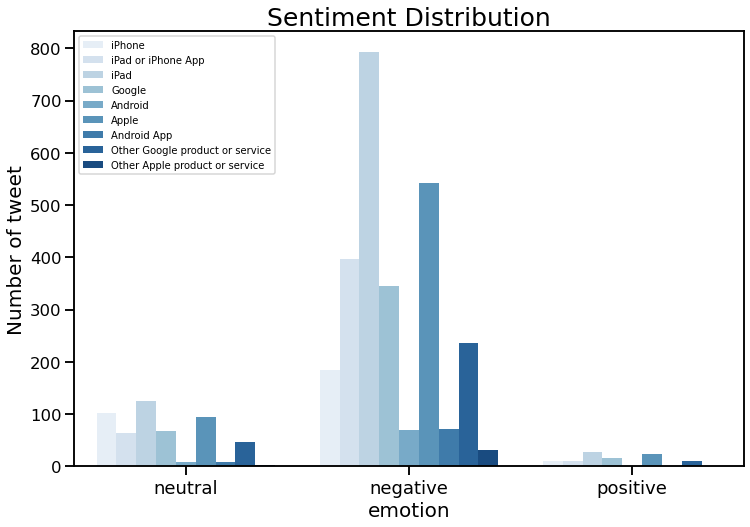

In [17]:
labels = ['neutral','negative','positive']
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data['emotion'], hue=data['product'], palette='Blues')
plt.title('Sentiment Distribution', fontsize=25)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('emotion',fontsize=20)
plt.ylabel('Number of tweet',fontsize=20)
plt.legend(loc=2, prop={'size': 10})
plt.show()

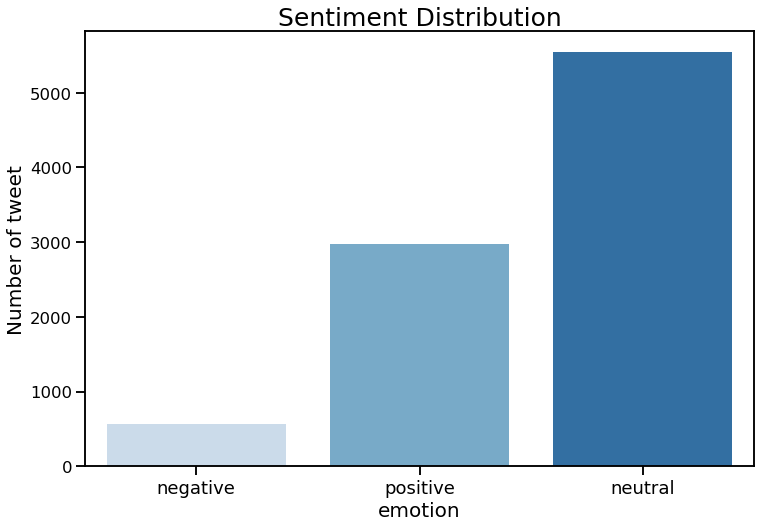

In [18]:
labels = ['negative','positive', 'neutral']
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x= data['emotion'], palette='Blues')
plt.title('Sentiment Distribution', fontsize=25)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('emotion',fontsize=20)
plt.ylabel('Number of tweet',fontsize=20)
#plt.legend(loc=2, prop={'size': 10})
plt.show()

In [42]:
#!pip install wordcloud
from wordcloud import WordCloud

all_words = ''.join([word for word in X_train['clean_tweet']])
building a wordcloud on the data from all tweets
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Data Preparation
- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

Code for data cleaning

In [19]:
# we need to map the target since everything will need to be an int. when modeling

def map_target(x):
    if x == 'Positive emotion':
        return 2
    elif x == 'Negative emotion':
        return 1
    else:
        return 0

In [20]:
data['target'] = data['emotion'].apply(map_target)
data['target'].value_counts(dropna=False,normalize=True)

0    0.609767
2    0.327541
1    0.062692
Name: target, dtype: float64

In [21]:
# split the data at start to aviod data leakage

target = 'target'

y = data[target]
X = data.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [22]:
# out of curiosity we can look at ther % of each sediment in the 
# train and test data as a reference to how well divided the data is 

print("Train percent vaccinated:", y_train.value_counts(normalize=True))
print('-------------')
print("Test percent vaccinated: ", y_test.value_counts(normalize=True))

Train percent vaccinated: 0    0.609767
2    0.327614
1    0.062619
Name: target, dtype: float64
-------------
Test percent vaccinated:  0    0.609767
2    0.327321
1    0.062912
Name: target, dtype: float64


In [23]:
#from nltk import word_tokenize
#import nltk
#nltk.download('punkt')
#from nltk import TweetTokenizer
tokenizer = TweetTokenizer()
#import warnings
#warnings.filterwarnings('ignore')                    
                           
#applying TweetTokenize to both training and test sets
X_train["tweet_text"]=X_train["tweet_text"].apply(tokenizer.tokenize)
X_test["tweet_text"]=X_test["tweet_text"].apply(tokenizer.tokenize)
X_train.head()

,tweet_text,product,emotion
2689,"[Get, to, the, nav, schemes, I, am, done, with...",NaN,No emotion toward brand or product
4535,"[Whoa, -, line, for, ipad, 2, is, 3blks, long,...",NaN,Positive emotion
2819,"[just, walked, by, the, line, for, the, iPad, ...",iPad,Negative emotion
1156,"[Oh, ,, ', ware, the, Ides, of, March, ., Loca...",NaN,No emotion toward brand or product
7638,"[I, was, there, ., It, was, nuts, ., RT, @ment...",iPad,Positive emotion


In [24]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
stopwords_list.extend(string.punctuation)
#remove stopwords from both training and test set
X_train["tweet_text"] = X_train["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])
X_test["tweet_text"] = X_test["tweet_text"].apply(lambda x: [item for item in x if item not in stopwords_list])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachelfein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
X_train["tweet_text"] = X_train["tweet_text"].apply(lambda x: ' '.join([w for w in x if len(w)>2]))
X_test["tweet_text"] = X_test["tweet_text"].apply(lambda x: ' '.join([w for w in x if len(w)>2]))

In [26]:
X_train["tweet_text"] = X_train["tweet_text"].str.lower()
X_test["tweet_text"] = X_test["tweet_text"].str.lower()

In [27]:
import re
shortword = re.compile(r'\W*\b\w{1,3}\b')
#altered_string = re.sub(',', '', my_string)
#print('My new string: {}'.format(altered_string))
#find_commas = re.compile()

def cleaner(tweet):
    
    tweet = re.sub(r'@[A-Za-z0-9]+','', str(tweet)) # removes @
    tweet = re.sub(r'#', '', str(tweet)) # removes hashtag
    tweet = re.sub(r'RT[\s]+','', str(tweet)) # removes RT
    tweet = re.sub(r'https?:\/\/\S+', '', tweet) # remove hyperlink in tweet
    tweet = re.sub(r'[^\w\s]', '', tweet) # removes punctuations
    tweet = re.sub(r',', '', str(tweet)) # remove commas 
    tweet = shortword.sub('', tweet)
    

    return tweet

X_train["tweet_text"] = X_train["tweet_text"].apply(cleaner)

In [28]:
X_train

,tweet_text,product,emotion
2689,schemes done ipad shape lesson sxsw,NaN,No emotion toward brand or product
4535,whoa line ipad 3blks long apple austin sxsw,NaN,Positive emotion
2819,walked line ipad bahahahaha least blocks long ...,iPad,Negative emotion
1156,ware ides march location link sxsw,NaN,No emotion toward brand or product
7638,nuts ipad hand awesome dude gave cutsies hour...,iPad,Positive emotion
...,...,...,...
2744,great austin convention center today showing ...,iPad or iPhone App,Positive emotion
8743,waiting outside sxsw apple store ipad2 woohoo,iPad,Positive emotion
2586,taking ipad plunge sxsw popup store congress k...,NaN,No emotion toward brand or product
847,tech lone dude awaits ipad_2 apple sxsw store ...,NaN,No emotion toward brand or product


In [29]:
X_test["tweet_text"] = X_test["tweet_text"].apply(cleaner)

In [30]:
X_test

,tweet_text,product,emotion
5118,cool that means watch ustream skyfire browse...,iPad or iPhone App,Positive emotion
2696,apple employees showed force sxsw popup appl...,iPad,Positive emotion
9087,ipad everywhere sxsw link,iPad,Positive emotion
873,amazes many people tuck flap apple ipad case sxsw,NaN,No emotion toward brand or product
1007,check poked liked retweeted google love story ...,NaN,No emotion toward brand or product
...,...,...,...
2172,launched ipad sxsw details first edition free ...,NaN,No emotion toward brand or product
742,sxsw keep great craftbeer drinking austin next...,NaN,No emotion toward brand or product
5551,behind 100s emails give line iphone composed ...,NaN,No emotion toward brand or product
5044,know using little jazz hands said pushio ipad...,NaN,No emotion toward brand or product


In [31]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_tokenizer = WordNetLemmatizer()
X_train["tweet_text"] = X_train["tweet_text"].apply(wordnet_tokenizer.lemmatize)
X_test["tweet_text"] = X_test["tweet_text"].apply(wordnet_tokenizer.lemmatize)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rachelfein/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
X_test

,tweet_text,product,emotion
5118,cool that means watch ustream skyfire browse...,iPad or iPhone App,Positive emotion
2696,apple employees showed force sxsw popup appl...,iPad,Positive emotion
9087,ipad everywhere sxsw link,iPad,Positive emotion
873,amazes many people tuck flap apple ipad case sxsw,NaN,No emotion toward brand or product
1007,check poked liked retweeted google love story ...,NaN,No emotion toward brand or product
...,...,...,...
2172,launched ipad sxsw details first edition free ...,NaN,No emotion toward brand or product
742,sxsw keep great craftbeer drinking austin next...,NaN,No emotion toward brand or product
5551,behind 100s emails give line iphone composed ...,NaN,No emotion toward brand or product
5044,know using little jazz hands said pushio ipad...,NaN,No emotion toward brand or product


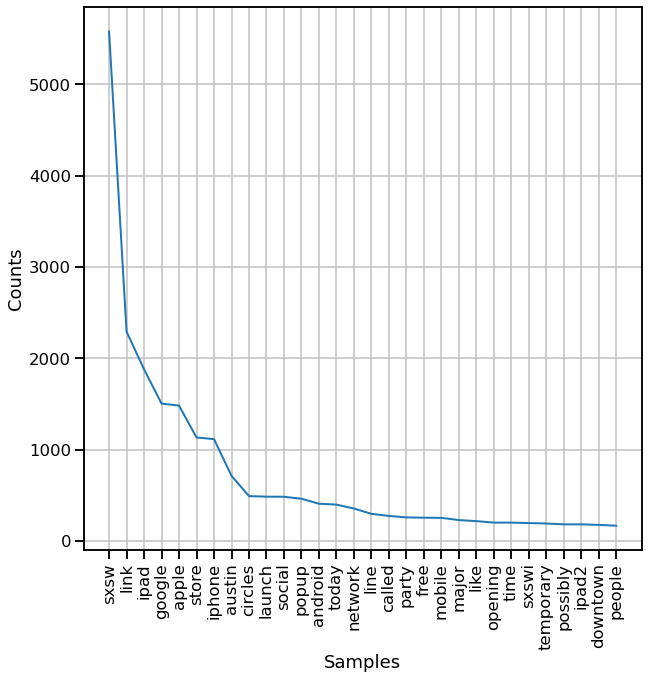

In [34]:
#freq_dis = nltk.FreqDist(X_train['tweet_text']) #number of occurances of each word
sentiment_words = ''.join([word for word in X_train['tweet_text']]) #words from the tweets that are positive
list_words = [ x for x in sentiment_words.split()] #list of positive sentiment words
fdist = nltk.FreqDist(list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

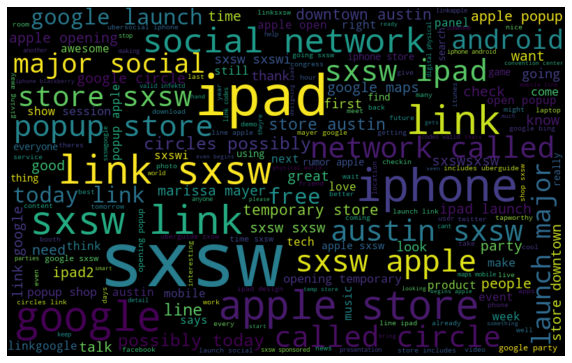

In [49]:
#building a wordcloud on the data from all tweets
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

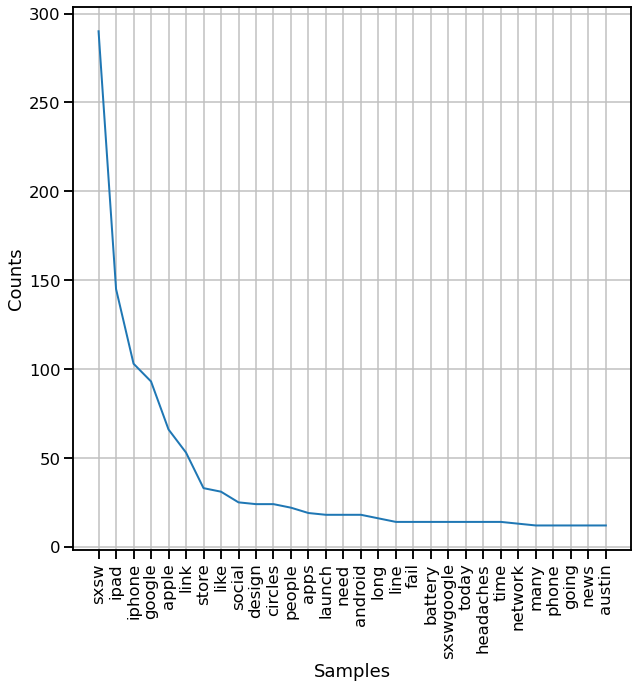

In [35]:
# lets see some of the most common words in negative tweets

neg = X_train[X_train["emotion"] == 'Negative emotion']
neg_sentiment_words = ''.join([word for word in neg['tweet_text']]) ##words from the tweets that are negative
neg_list_words = [ x for x in neg_sentiment_words.split()] #list of positive sentiment words
fdist = nltk.FreqDist(neg_list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

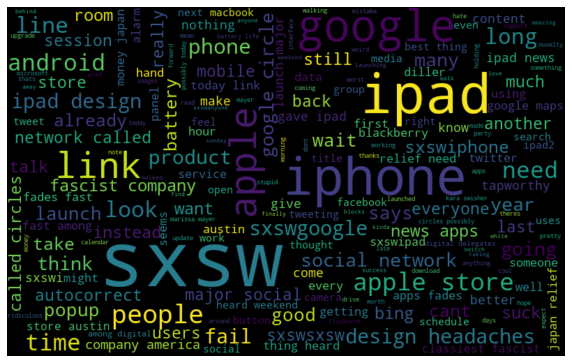

In [44]:
#building a wordcloud on the data from all tweets
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

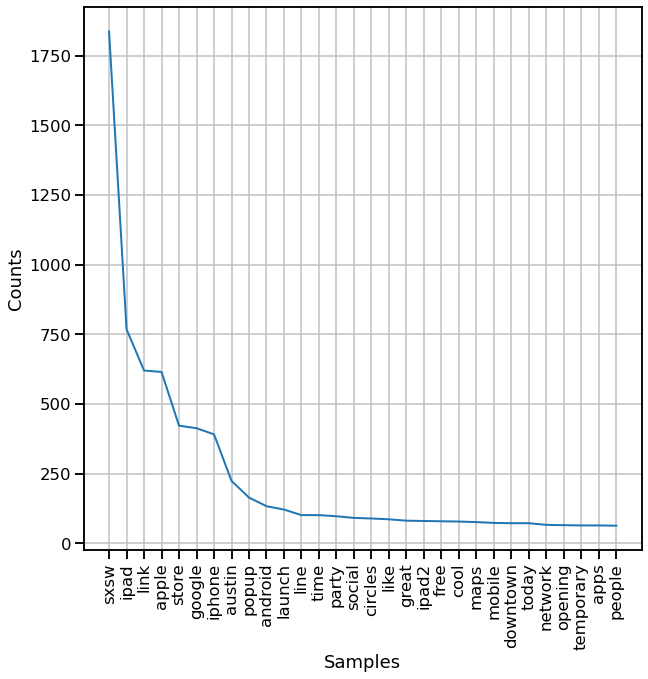

In [46]:
# lets see some of the most common words in negative tweets

pos = X_train[X_train["emotion"] == 'Positive emotion']
pos_sentiment_words = ''.join([word for word in pos['tweet_text']]) ##words from the tweets that are negative
pos_list_words = [ x for x in pos_sentiment_words.split()] #list of positive sentiment words
fdist = nltk.FreqDist(pos_list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

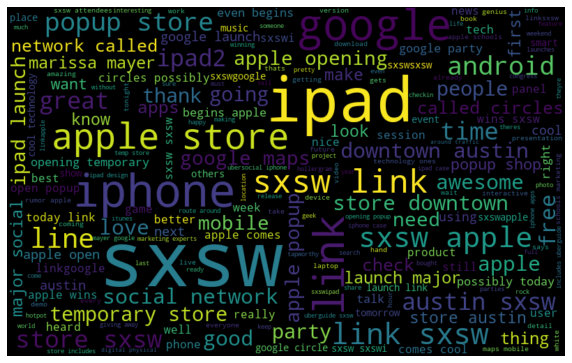

In [47]:
#building a wordcloud on the data from all tweets
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

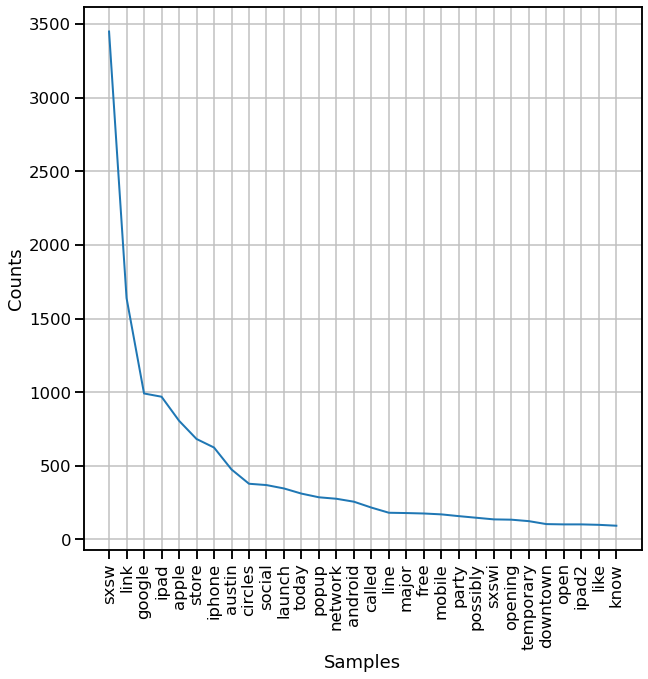

In [50]:
# lets see some of the most common words in negative tweets

nuetral = X_train[X_train["emotion"] == 'No emotion toward brand or product']
nuetral_sentiment_words = ''.join([word for word in nuetral['tweet_text']]) ##words from the tweets that are negative
nuetral_list_words = [ x for x in nuetral_sentiment_words.split()] #list of positive sentiment words
fdist = nltk.FreqDist(nuetral_list_words)
plt.figure(figsize=(10, 10))
fdist.plot(30);

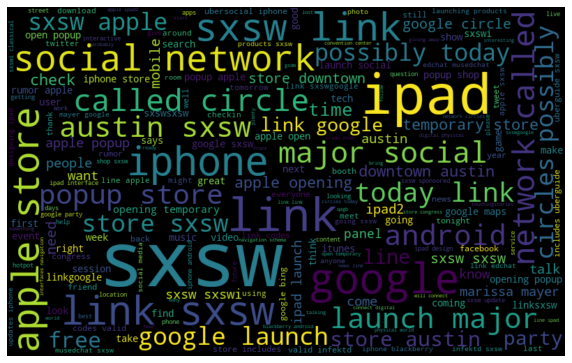

In [51]:
#building a wordcloud on the data from all tweets
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(nuetral_sentiment_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Interesting that sxsw and austin come up in both positive and negative tweets. After a google search I found out that SXSW is a annual festival in Austin, Texas.

In [33]:
# Import 


# Instantiate a vectorizer using TF-IDF. A max_df =.90 means that words in over 90% tweets are not used
tfidf = TfidfVectorizer(min_df = 2, max_df=.90)

# Fit the vectorizer on X_train["text"] and transform it
X_train_tfidf = tfidf.fit_transform(X_train['tweet_text'])


# Fit the vectorizer on X_train["text"] and transform it
X_test_tfidf = tfidf.transform(X_test['tweet_text']) 


# Visually inspect the vectorized train data
pd.DataFrame.sparse.from_spmatrix(X_train_tfidf, columns=tfidf.get_feature_names())

,0011,0311,0312,0313,0314,0315,1000,100s,1030,1100,...,zynga,û_time,ûªll,ûªre,ûïbest,ûïcheckin,ûïcoming,ûïthe,ûïwin,ûòand
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
y_hat_test = model.predict(X_test_tfidf)

In [48]:
# we know that the data is not balenced so we will need to deal with that first
from sklearn.metrics import plot_confusion_matrix

# make function to view model performance 
from sklearn import metrics
def model_eval(model, X_test_tfidf, y_test,
               normalize='true', return_fig=False,
               classes=None, figsize=(14, 6)):
    # Get Predictions
    y_hat_train = model.predict(X_train_tfidf)
    print('Classification Report for Training Set')
    print(metrics.classification_report(y_train, y_hat_train, target_names=classes))
    
    print('Classification Report for Testing Set')
    y_hat_test = model.predict(X_test_tfidf)
    print(metrics.classification_report(y_test, y_hat_test, target_names=classes))
    
    print("---------------------------------------")
    
    print(f'f1 train set: {metrics.f1_score(y_train,y_hat_train, average="weighted")}')
    print(f'f1 test set: {metrics.f1_score(y_test,y_hat_test, average="weighted")}')
    
    print("---------------------------------------")

    print('Confusion matrix for test set:')
    plot_confusion_matrix(model,X_test_tfidf,y_test, cmap='Blues', display_labels=classes);

    if return_fig:
        return fig,axes

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.95      0.98      0.96      4158
   Postitive       0.97      0.92      0.94       427
    Negative       0.97      0.91      0.94      2234

    accuracy                           0.95      6819
   macro avg       0.96      0.94      0.95      6819
weighted avg       0.95      0.95      0.95      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.70      0.88      0.78      1386
   Postitive       0.58      0.21      0.31       143
    Negative       0.66      0.42      0.52       744

    accuracy                           0.69      2273
   macro avg       0.65      0.51      0.54      2273
weighted avg       0.68      0.69      0.66      2273

---------------------------------------
f1 train set: 0.9526117424680263
f1 test set: 0.664516684558599
---------------------------------------
Confusion matrix 

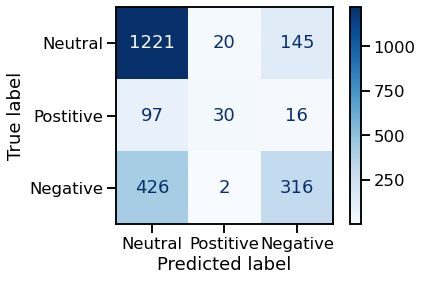

In [49]:
# set the fuction to the tree baseline model
rf_base = RandomForestClassifier()
model = rf_base.fit(X_train_tfidf,y_train)

model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [45]:
y_hat_test = model.predict(X_test_tfidf)
y_hat_train = model.predict(X_train_tfidf)
print(f'f1: {metrics.f1_score(y_test,y_hat_test, average="weighted")}')
print(f'f1: {metrics.f1_score(y_train,y_hat_train, average="weighted")}')

f1: 0.664951317686787
f1: 0.9526424005206903


In [39]:
from imblearn.over_sampling import SMOTE

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_tfidf, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 



2    4158
1    4158
0    4158
Name: target, dtype: int64


In [40]:
# we know that the data is not balanced so we will need to deal with that first

# make function to view model performance 
from sklearn import metrics
def model_eval_smote(model, X_test_tfidf, y_test,
               normalize='true', return_fig=False,
               classes=None, figsize=(14, 6)):
    # Get Predictions
    y_hat_train = model.predict(X_train_resampled)
    print('Classification Report for Training Set')
    print(metrics.classification_report(y_train_resampled, y_hat_train, target_names=classes))
    
    print('Classification Report for Testing Set')
    y_hat_test = model.predict(X_test_tfidf)
    print(metrics.classification_report(y_test, y_hat_test, target_names=classes))

    
    print("-------------")
    
        # Scores 
    print(dashes)
    print("MODEL EVALUATION")
    print(dashes)
    
    
    plot_confusion_matrix(model,X_test_tfidf,y_test, cmap='Blues', display_labels=classes);

    if return_fig:
        return fig,axes

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.95      0.97      0.96      4158
   Postitive       0.99      1.00      0.99      4158
    Negative       0.97      0.95      0.96      4158

    accuracy                           0.97     12474
   macro avg       0.97      0.97      0.97     12474
weighted avg       0.97      0.97      0.97     12474

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.71      0.83      0.76      1386
   Postitive       0.45      0.24      0.32       143
    Negative       0.61      0.47      0.53       744

    accuracy                           0.67      2273
   macro avg       0.59      0.51      0.54      2273
weighted avg       0.66      0.67      0.66      2273

-------------


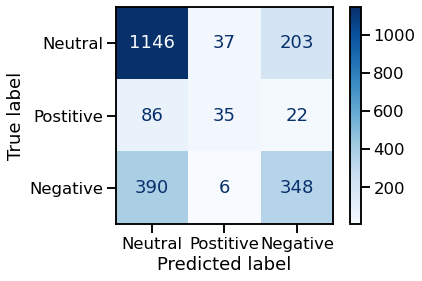

In [41]:
model = RandomForestClassifier()

model.fit(X_train_resampled, y_train_resampled)

model_eval_smote(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

SMOTE made the model worse, so we will stick with the orginal distributed data.

In [86]:
model = rf_base.fit(X_train_tfidf,y_train)

param = {'criterion': ['gini', 'entropy'],
         'n_estimators':[200, 250],
         'min_samples_split': [8, 10, 15],
         'min_samples_leaf': [2, 3, 4]
    
}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param, cv= 5, scoring=f1)

#Run search & takes a min or two
gridsearch.fit(X_train_tfidf,y_train)
gridsearch.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 250}

In [88]:
param = {'criterion': ['gini'],
         'n_estimators':[250, 280],
         'min_samples_split': [6,8],
         'min_samples_leaf': [2]
    
}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param, cv=5, scoring=f1)

#Run search & takes a min or two
gridsearch.fit(X_train_tfidf,y_train)
gridsearch.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 250}

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.80      0.97      0.88      4158
   Postitive       0.96      0.29      0.45       427
    Negative       0.90      0.66      0.76      2234

    accuracy                           0.83      6819
   macro avg       0.89      0.64      0.70      6819
weighted avg       0.84      0.83      0.81      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.69      0.92      0.79      1386
   Postitive       0.77      0.12      0.21       143
    Negative       0.69      0.37      0.48       744

    accuracy                           0.69      2273
   macro avg       0.72      0.47      0.49      2273
weighted avg       0.69      0.69      0.65      2273

-------------


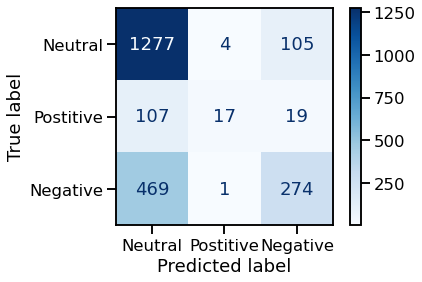

In [89]:
params = gridsearch.best_params_
model = RandomForestClassifier(**params)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

RandomForest isnt producing a good model, lets try a logistic Regression model & see if that will improve the results

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.94      0.96      0.95      4158
   Postitive       0.95      0.94      0.94       427
    Negative       0.92      0.90      0.91      2234

    accuracy                           0.94      6819
   macro avg       0.94      0.93      0.93      6819
weighted avg       0.94      0.94      0.94      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.72      0.68      0.70      1386
   Postitive       0.26      0.37      0.30       143
    Negative       0.52      0.53      0.52       744

    accuracy                           0.61      2273
   macro avg       0.50      0.53      0.51      2273
weighted avg       0.63      0.61      0.62      2273

-------------


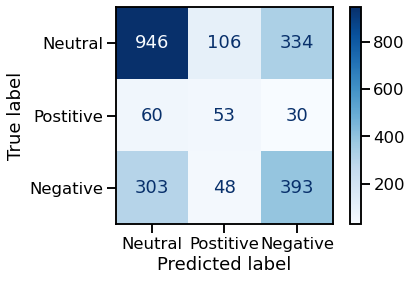

In [90]:
# Import functions needed
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Set a C value, this tells the model how to choose the parameters & how much 
# weight to but on the training data a low C will be a more complex model but risks over fitting 
model = LogisticRegression(max_iter=5000, C=1e12)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [57]:
y_hat_test = model.predict(X_test_tfidf)
print(f'f1: {metrics.f1_score(y_test,y_hat_test, average="weighted")}')

f1: 0.6148674222991377


In [ ]:
model = LogisticRegression(max_iter=5000)

param = {'penalty': ['l2', 'l1'],
         'solver': ['liblinear', 'saga']}

gridsearch = GridSearchCV(estimator=model,
                          param_grid=param, cv=5)

#Run search & takes a min or two
gridsearch.fit(X_train_tfidf,y_train)
gridsearch.best_params_

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.78      0.95      0.86      4158
   Postitive       0.93      0.19      0.32       427
    Negative       0.84      0.63      0.72      2234

    accuracy                           0.80      6819
   macro avg       0.85      0.59      0.63      6819
weighted avg       0.81      0.80      0.78      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.70      0.88      0.78      1386
   Postitive       0.71      0.08      0.15       143
    Negative       0.63      0.45      0.52       744

    accuracy                           0.69      2273
   macro avg       0.68      0.47      0.48      2273
weighted avg       0.68      0.69      0.66      2273

-------------


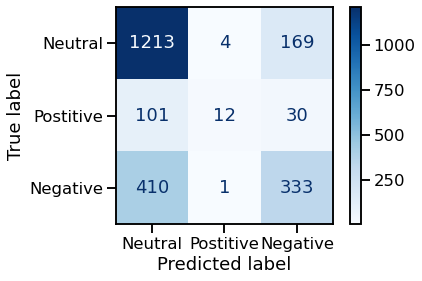

In [47]:
params = gridsearch.best_params_
model = LogisticRegression(max_iter=5000, **params)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [82]:
model = MultinomialNB()
param = {'alpha':[0,1]}

gridsearch = GridSearchCV(model,
                          param_grid=param, cv= 5, scoring=f1)

#Run search & takes a min or two
gridsearch.fit(X_train_tfidf,y_train)
gridsearch.best_params_


{'alpha': 0}

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.83      0.92      0.87      4158
   Postitive       0.82      0.67      0.74       427
    Negative       0.83      0.70      0.76      2234

    accuracy                           0.83      6819
   macro avg       0.83      0.76      0.79      6819
weighted avg       0.83      0.83      0.83      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.71      0.82      0.76      1386
   Postitive       0.50      0.22      0.31       143
    Negative       0.58      0.47      0.52       744

    accuracy                           0.67      2273
   macro avg       0.60      0.50      0.53      2273
weighted avg       0.65      0.67      0.65      2273

-------------


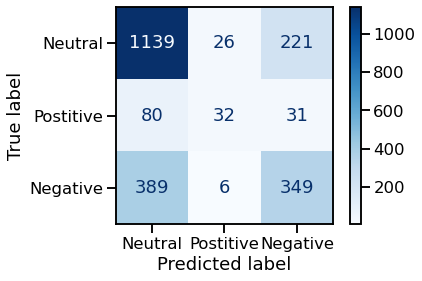

In [83]:
params = gridsearch.best_params_
model = MultinomialNB(**params)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

Classification Report for Training Set
              precision    recall  f1-score   support

     Neutral       0.74      0.97      0.84      4158
   Postitive       0.95      0.10      0.17       427
    Negative       0.84      0.50      0.63      2234

    accuracy                           0.76      6819
   macro avg       0.84      0.52      0.55      6819
weighted avg       0.79      0.76      0.73      6819

Classification Report for Testing Set
              precision    recall  f1-score   support

     Neutral       0.67      0.92      0.77      1386
   Postitive       0.89      0.06      0.11       143
    Negative       0.63      0.30      0.41       744

    accuracy                           0.66      2273
   macro avg       0.73      0.43      0.43      2273
weighted avg       0.67      0.66      0.61      2273

-------------


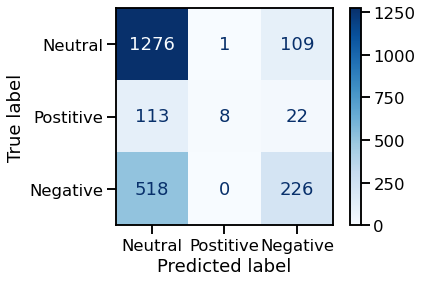

In [70]:
params = gridsearch.best_params_
model = RandomForestClassifier(**params)
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);



clf = MultinomialNB()
# use a full grid over all parameters
param_grid = {'alpha':[0,1] }
f1 = make_scorer(f1_score , average='weighted')
# run grid search
grid = GridSearchCV(clf, cv=5,scoring=f1, param_grid=param_grid)
grid.fit(X_train_tfidf,y_train)
print("Grid-Search with roc_auc")
print("Best parameters:", grid.best_params_)



model = MultinomialNB()
model.fit(X_train_tfidf,y_train)
model_eval(model,X_test_tfidf,y_test, classes=['Neutral', 'Postitive', 'Negative']);

In [67]:


#clf = MultinomialNB()
# use a full grid over all parameters
#param_grid = {'alpha':[0,1] }
#f1 = make_scorer(f1_score , average='weighted')
# run grid search
#grid = GridSearchCV(clf, cv=5,scoring=f1, param_grid=param_grid)
#grid.fit(X_train_tfidf,y_train)
#print("Grid-Search with roc_auc")
#print("Best parameters:", grid.best_params_)
#print("Best cross-validation score (f1)): {:.3f}".format(grid.best_score_))
#y_predict = grid.predict(X_test_tfidf)
#rint('The weighted F1 score with the best hyperparameters is ', end = '')
#print(f1_score(y_test, y_predict, average='weighted'))
#print ("Classification Report: ")
#print (classification_report(y_test, y_predict))

Grid-Search with roc_auc
Best parameters: {'alpha': 0}
Best cross-validation score (f1)): 0.645
The weighted F1 score with the best hyperparameters is 0.6532614284095963
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1386
           1       0.50      0.22      0.31       143
           2       0.58      0.47      0.52       744

    accuracy                           0.67      2273
   macro avg       0.60      0.50      0.53      2273
weighted avg       0.65      0.67      0.65      2273



Business problem
Who to send promoted ads to only nuetral or positive tweets to ecurage people to upgrade their devices. With a promated tweet costing $0.50 t0 $2 an action, your team has already decided that you want to put your marketing cost towards people who have been detected to already have an intrest in Google or Apple products. We have choosen to eliminate those who already have a negative view of the brands as a promoted ad to them would be a waist of your crucial marketing budget. 